In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, Dropout, Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from rnn.model import (Model, EmbeddingLayer, SimpleRNNLayer,
                           BidirectionalSimpleRNNLayer, DenseLayer, DropoutLayer)


# 2. Ensure deterministic behavior (for GPU
from tensorflow.keras import backend as K
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
train = pd.read_csv("../data/train.csv")
val = pd.read_csv("../data/valid.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
X_train = train["text"].astype(str).values
X_val = val["text"].values

y_train = train["label"].astype(str).values
y_val = val["label"].values

max_tokens = 5000  # Maximum vocab size.
max_len = 100  # Sequence length to pad the outputs to.

vectorize_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_train)

X_train = vectorize_layer(X_train)
X_val = vectorize_layer(X_val)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Variasi Kombinasi Banyak Layer RNN

In [4]:
def build_model_rnn_layer(num_layers):
  SEED = 42
  os.environ['PYTHONHASHSEED'] = str(SEED)
  random.seed(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  model = Sequential()
  model.add(Embedding(input_dim=max_tokens, output_dim=128))

  for i in range(num_layers):
    return_seq = i != num_layers - 1
    model.add(Bidirectional(SimpleRNN(64, return_sequences=return_seq)))
    model.add(Dropout(0.2))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(3, activation='softmax'))

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [5]:
models_layer = {}
for num_layer in range(1, 6, 2):
  print(f"Training model with {num_layer} layer")
  model = build_model_rnn_layer(num_layer)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
  models_layer[num_layer] = {"model" : model, "history" : history}
  print()

Training model with 1 layer
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.4528 - loss: 1.0670 - val_accuracy: 0.4900 - val_loss: 0.9603
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6315 - loss: 0.8747 - val_accuracy: 0.5600 - val_loss: 0.9109
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8215 - loss: 0.6123 - val_accuracy: 0.6000 - val_loss: 0.8235
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9603 - loss: 0.2855 - val_accuracy: 0.5900 - val_loss: 0.8457
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9880 - loss: 0.0872 - val_accuracy: 0.6200 - val_loss: 0.9759
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9964 - loss: 0.0314 - val_accuracy: 0.5100 - val_loss: 1.2964
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.5800 - val_loss: 1.1516
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.

## 1 Layer

In [ ]:
num_layer = 1
model = models_layer[num_layer]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


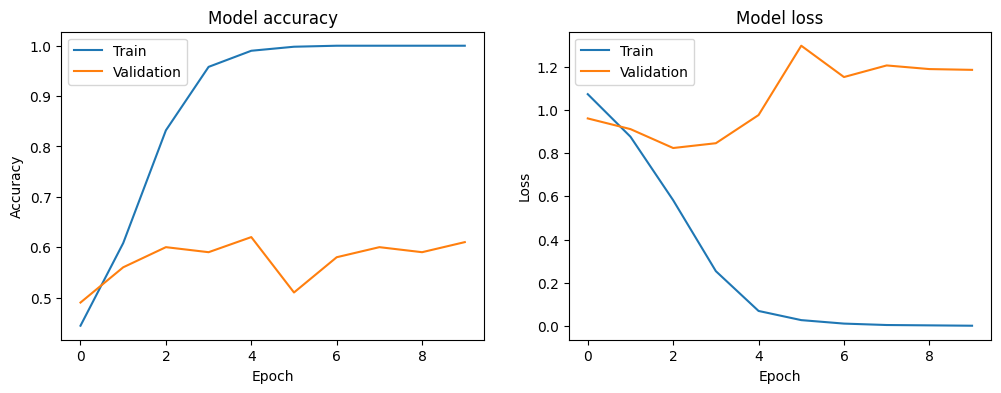

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_layer[num_layer]["history"].history['accuracy'])
plt.plot(models_layer[num_layer]["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_layer[num_layer]["history"].history['loss'])
plt.plot(models_layer[num_layer]["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

              precision    recall  f1-score   support

    negative       0.59      0.52      0.56       153
     neutral       0.56      0.60      0.58        96
    positive       0.74      0.79      0.77       151

    accuracy                           0.65       400
   macro avg       0.63      0.64      0.64       400
weighted avg       0.64      0.65      0.64       400



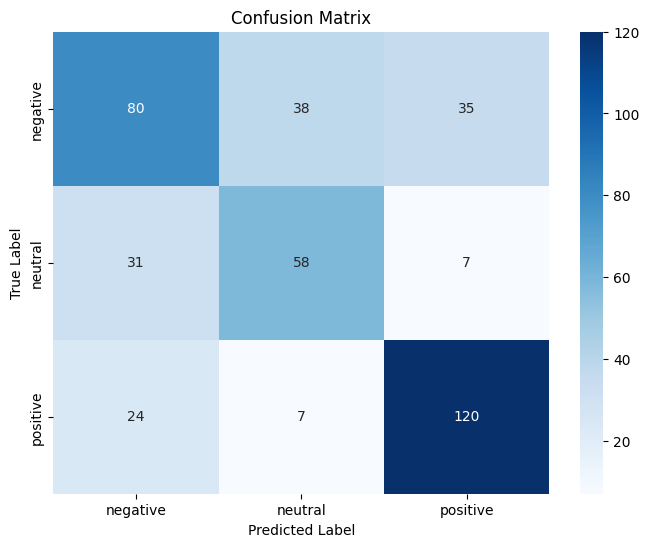

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3 Layer

In [ ]:
num_layer = 3
model = models_layer[num_layer]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step


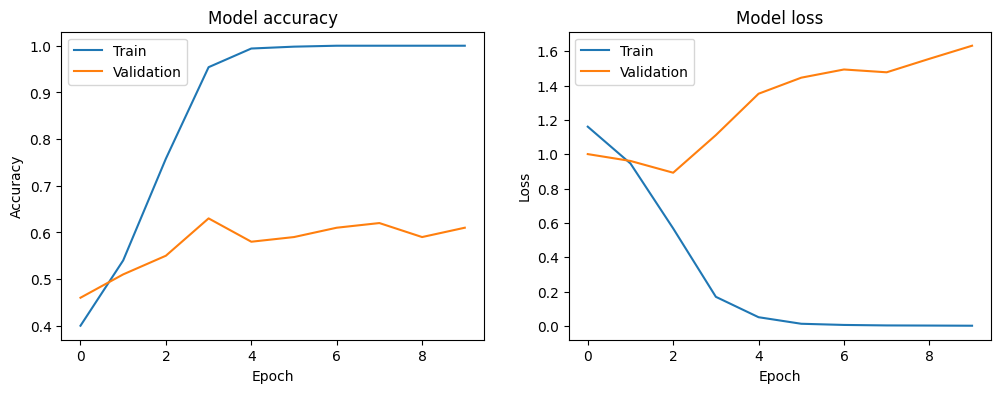

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_layer[num_layer]["history"].history['accuracy'])
plt.plot(models_layer[num_layer]["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_layer[num_layer]["history"].history['loss'])
plt.plot(models_layer[num_layer]["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

              precision    recall  f1-score   support

    negative       0.47      0.50      0.49       153
     neutral       0.39      0.39      0.39        96
    positive       0.66      0.63      0.64       151

    accuracy                           0.52       400
   macro avg       0.51      0.50      0.51       400
weighted avg       0.52      0.52      0.52       400



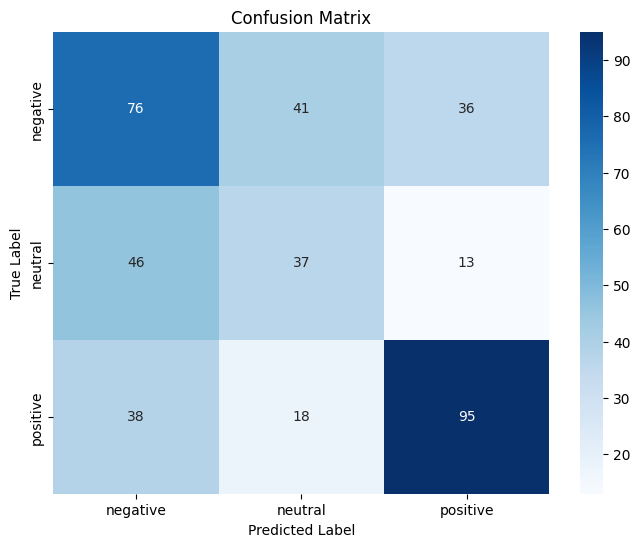

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 5 Layer

In [ ]:
num_layer = 5
model = models_layer[num_layer]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step


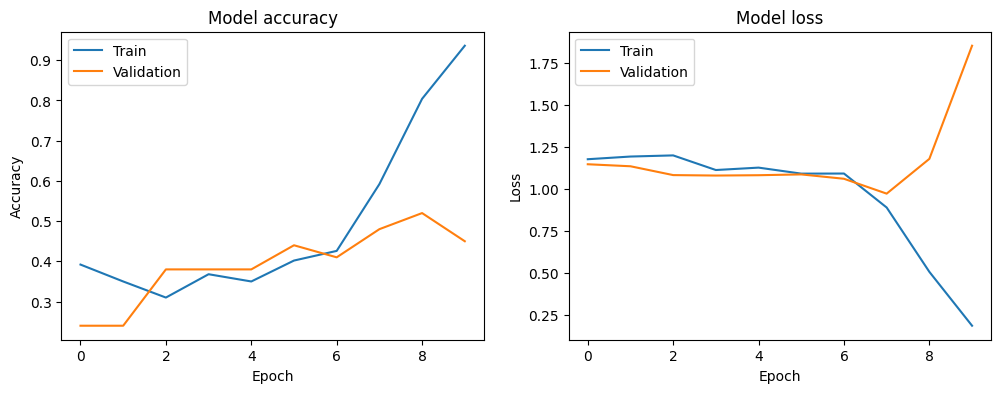

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_layer[num_layer]["history"].history['accuracy'])
plt.plot(models_layer[num_layer]["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_layer[num_layer]["history"].history['loss'])
plt.plot(models_layer[num_layer]["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

              precision    recall  f1-score   support

    negative       0.53      0.33      0.40       153
     neutral       0.33      0.77      0.46        96
    positive       0.88      0.46      0.61       151

    accuracy                           0.48       400
   macro avg       0.58      0.52      0.49       400
weighted avg       0.61      0.48      0.49       400



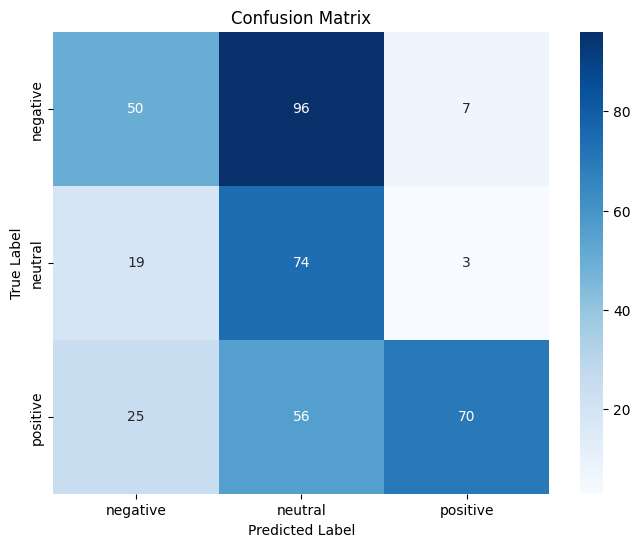

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Variasi Kombinasi Banyak Cell RNN Per Layer

In [ ]:
def build_model_rnn_cells(num_cells):
  SEED = 42
  os.environ['PYTHONHASHSEED'] = str(SEED)
  random.seed(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  model = Sequential()
  model.add(Embedding(input_dim=max_tokens, output_dim=128))

  model.add(Bidirectional(SimpleRNN(num_cells, return_sequences=False)))
  model.add(Dropout(0.2))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(3, activation='softmax'))

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
num_cell_list = [16, 64, 256]
models_cells = {}
for num_cells in num_cell_list:
  print(f"Training model with {num_cells} cells")
  model = build_model_rnn_cells(num_cells)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
  models_cells[num_cells] = {"model" : model, "history" : history}
  print()

Training model with 16 cells
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.4384 - loss: 1.0760 - val_accuracy: 0.5600 - val_loss: 0.9833
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6925 - loss: 0.8608 - val_accuracy: 0.5900 - val_loss: 0.8876
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8852 - loss: 0.5595 - val_accuracy: 0.5500 - val_loss: 0.8733
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9575 - loss: 0.2750 - val_accuracy: 0.5900 - val_loss: 0.9273
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9883 - loss: 0.1162 - val_accuracy: 0.5600 - val_loss: 1.1034
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9905 - loss: 0.0641 - val_accuracy: 0.5500 - val_loss: 1.2908
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9939 - loss: 0.0316 - val_accuracy: 0.5400 - val_loss: 1.4643
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9964 - loss: 0.0

## 16 cell

In [ ]:
num_cells = 16
model = models_cells[num_cells]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


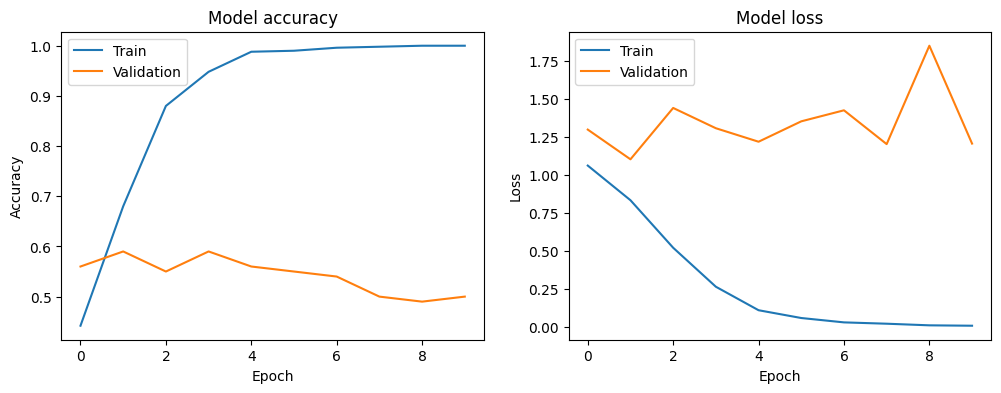

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_cells[num_cells]["history"].history['accuracy'])
plt.plot(models_cells[num_cells]["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_cells[num_cells]["history"].history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

              precision    recall  f1-score   support

    negative       0.53      0.54      0.53       153
     neutral       0.48      0.61      0.54        96
    positive       0.79      0.64      0.71       151

    accuracy                           0.59       400
   macro avg       0.60      0.60      0.59       400
weighted avg       0.62      0.59      0.60       400



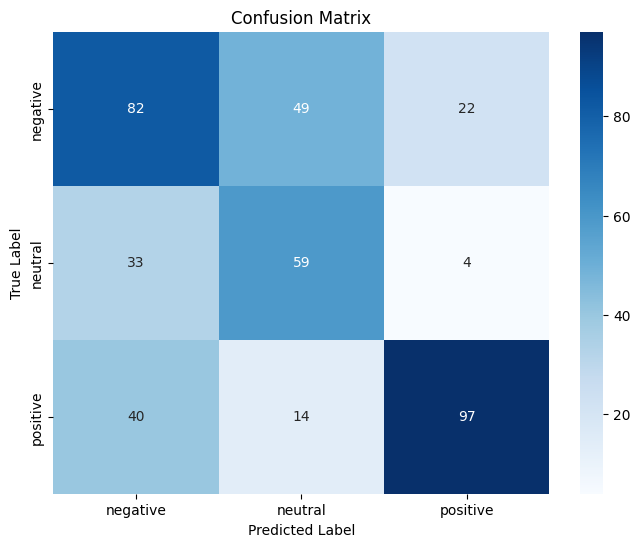

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 64 cell

In [ ]:
num_cells = 64
model = models_cells[num_cells]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


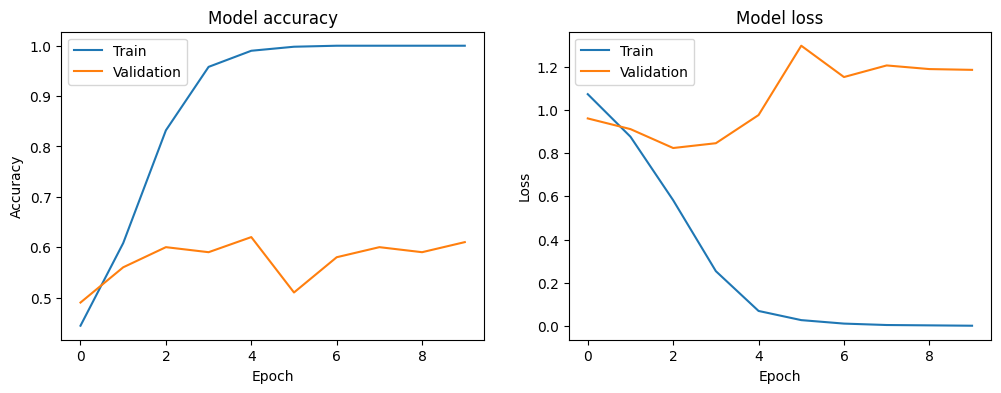

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_cells[num_cells]["history"].history['accuracy'])
plt.plot(models_cells[num_cells]["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_cells[num_cells]["history"].history['loss'])
plt.plot(models_cells[num_cells]["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

              precision    recall  f1-score   support

    negative       0.59      0.52      0.56       153
     neutral       0.56      0.60      0.58        96
    positive       0.74      0.79      0.77       151

    accuracy                           0.65       400
   macro avg       0.63      0.64      0.64       400
weighted avg       0.64      0.65      0.64       400



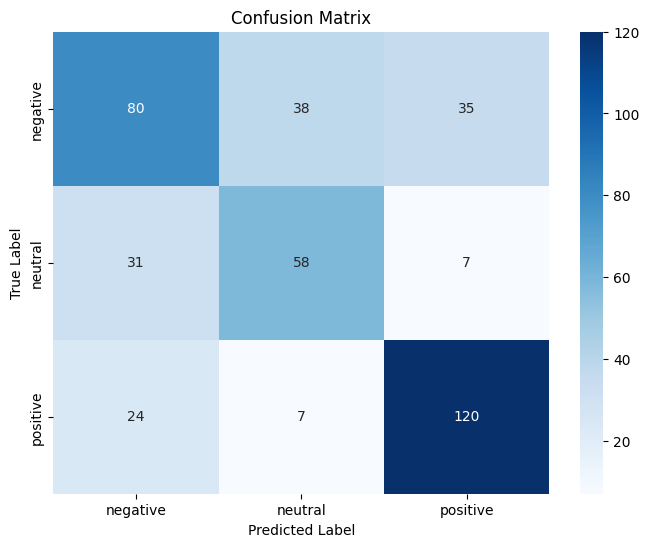

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 256 cell

In [ ]:
num_cells = 256
model = models_cells[num_cells]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


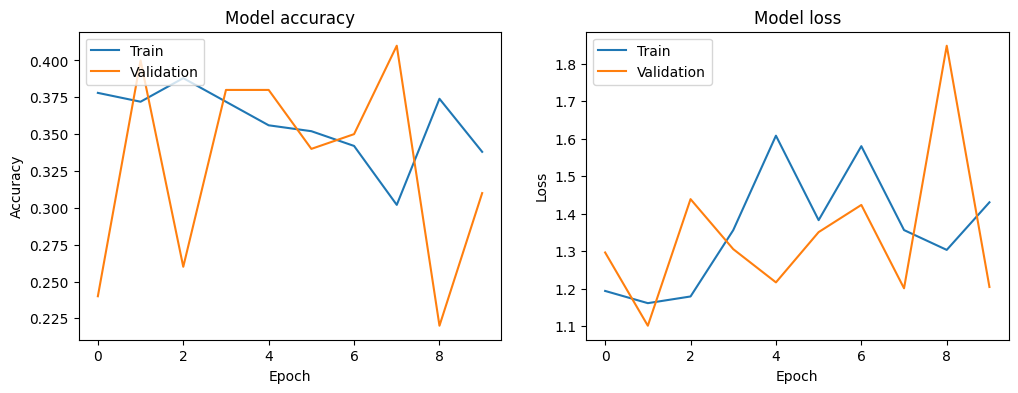

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_cells[num_cells]["history"].history['accuracy'])
plt.plot(models_cells[num_cells]["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_cells[num_cells]["history"].history['loss'])
plt.plot(models_cells[num_cells]["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: U

              precision    recall  f1-score   support

    negative       0.41      0.63      0.49       153
     neutral       0.00      0.00      0.00        96
    positive       0.37      0.39      0.38       151

    accuracy                           0.39       400
   macro avg       0.26      0.34      0.29       400
weighted avg       0.29      0.39      0.33       400



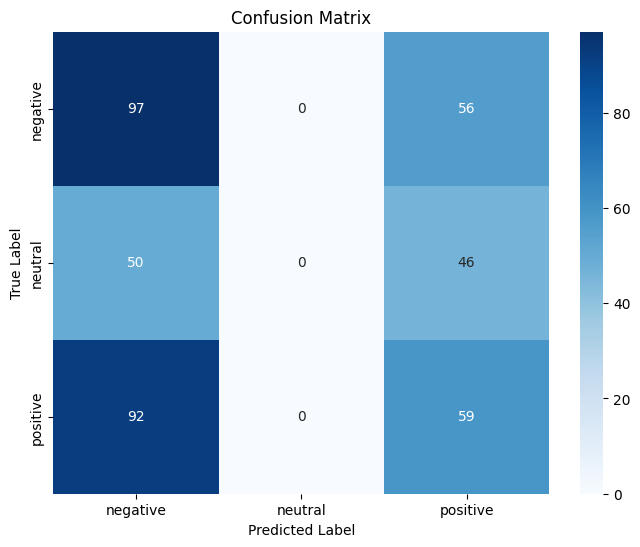

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Variasi Jenis Layer RNN Berdasarkan Arah

In [ ]:
def build_model_rnn_direction(type_direction):
  SEED = 42
  os.environ['PYTHONHASHSEED'] = str(SEED)
  random.seed(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  model = Sequential()
  model.add(Embedding(input_dim=max_tokens, output_dim=128))

  if type_direction == 'bidirectional':
    model.add(Bidirectional(SimpleRNN(64, return_sequences=False)))
    model.add(Dropout(0.2))
  else:
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dropout(0.2))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(3, activation='softmax'))

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
directions = ["unidirectional", "bidirectional"]
models_direction = {}
for direction in directions:
  print(f"Training model with {direction} layer")
  model = build_model_rnn_direction(direction)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
  models_direction[direction] = {"model" : model, "history" : history}
  print()

Training model with unidirectional layer
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.3560 - loss: 1.0917 - val_accuracy: 0.3900 - val_loss: 1.0965
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4819 - loss: 1.0550 - val_accuracy: 0.3800 - val_loss: 1.1186
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5029 - loss: 1.0226 - val_accuracy: 0.3400 - val_loss: 1.2553
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4131 - loss: 1.1035 - val_accuracy: 0.3900 - val_loss: 1.1138
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3763 - loss: 1.0922 - val_accuracy: 0.4100 - val_loss: 1.0994
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4758 - loss: 1.0517 - val_accuracy: 0.4000 - val_loss: 1.1294
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4309 - loss: 1.0825 - val_accuracy: 0.3700 - val_loss: 1.1016
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.325

## Unidirectional

In [ ]:
direction = "unidirectional"
model = models_direction[direction]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


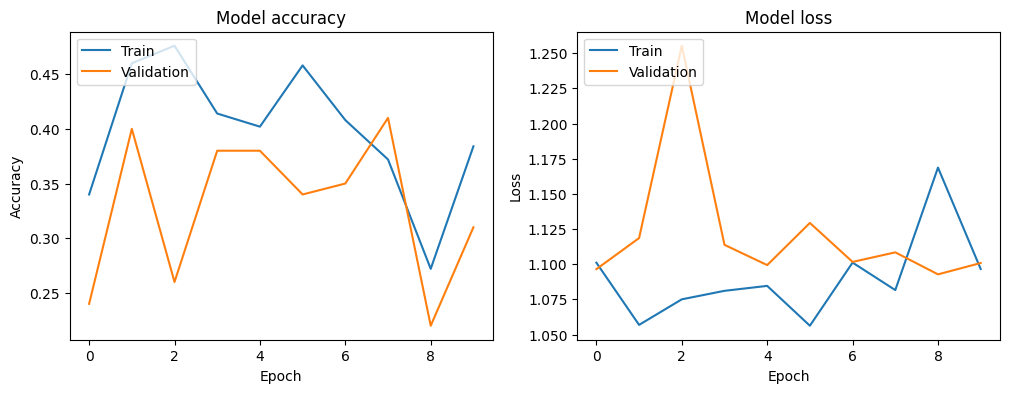

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_direction['unidirectional']["history"].history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_direction['unidirectional']["history"].history['loss'])
plt.plot(models_direction['unidirectional']["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: U

              precision    recall  f1-score   support

    negative       0.39      0.63      0.48       153
     neutral       0.00      0.00      0.00        96
    positive       0.38      0.39      0.39       151

    accuracy                           0.39       400
   macro avg       0.26      0.34      0.29       400
weighted avg       0.29      0.39      0.33       400



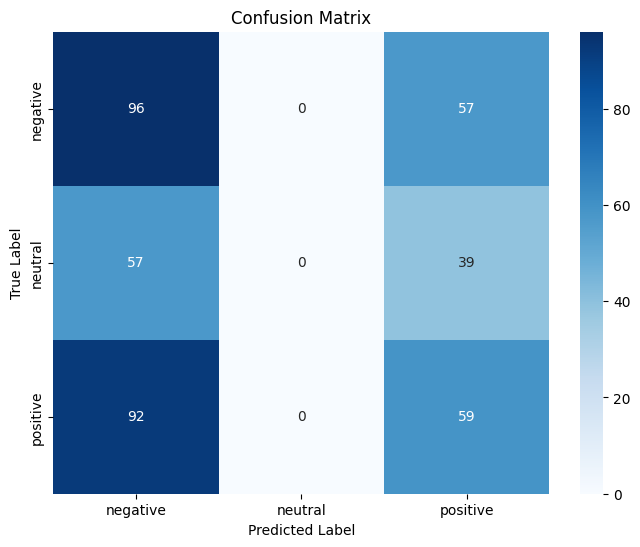

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Bidirectional

In [ ]:
direction = "bidirectional"
model = models_direction[direction]["model"]
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


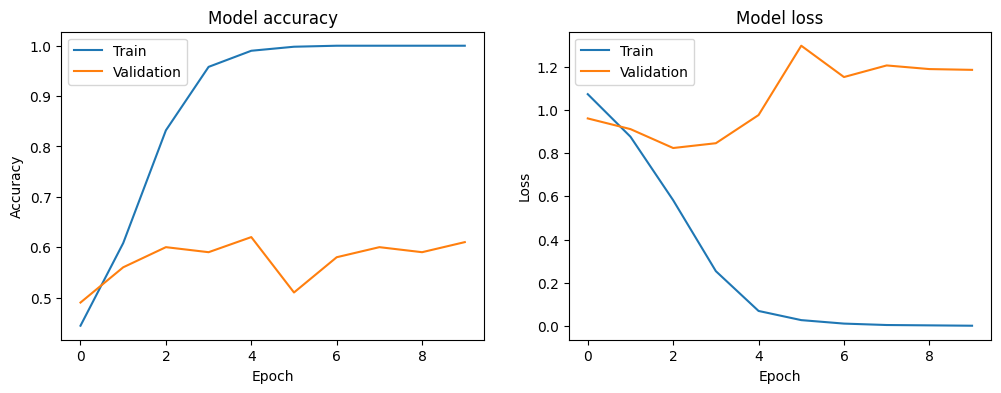

In [ ]:
# visualization for model training process per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(models_direction['bidirectional']["history"].history['accuracy'])
plt.plot(models_direction['bidirectional']["history"].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(models_direction['bidirectional']["history"].history['loss'])
plt.plot(models_direction['bidirectional']["history"].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

              precision    recall  f1-score   support

    negative       0.59      0.52      0.56       153
     neutral       0.56      0.60      0.58        96
    positive       0.74      0.79      0.77       151

    accuracy                           0.65       400
   macro avg       0.63      0.64      0.64       400
weighted avg       0.64      0.65      0.64       400



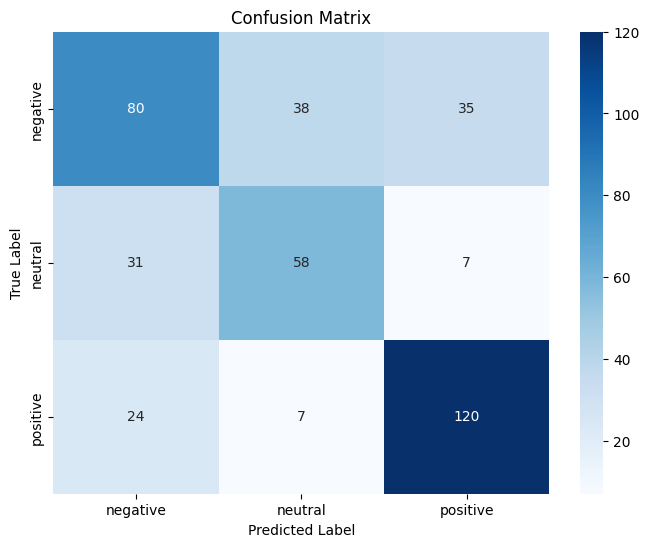

In [ ]:
print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Uji Implementasi Forward Propagation RNN From Scratch

In [6]:
test = pd.read_csv("../data/test.csv")

X_test = test["text"].astype(str).values
y_test = test["label"].values

X_test = vectorize_layer(X_test)

y_test = label_encoder.transform(y_test)

## Uji Model Unidirectional 

Processing Layers: |████████████████████████████████████████| 100.00%
              precision    recall  f1-score   support

    negative       0.39      0.63      0.48       153
     neutral       0.00      0.00      0.00        96
    positive       0.38      0.39      0.39       151

    accuracy                           0.39       400
   macro avg       0.26      0.34      0.29       400
weighted avg       0.29      0.39      0.33       400



C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: U

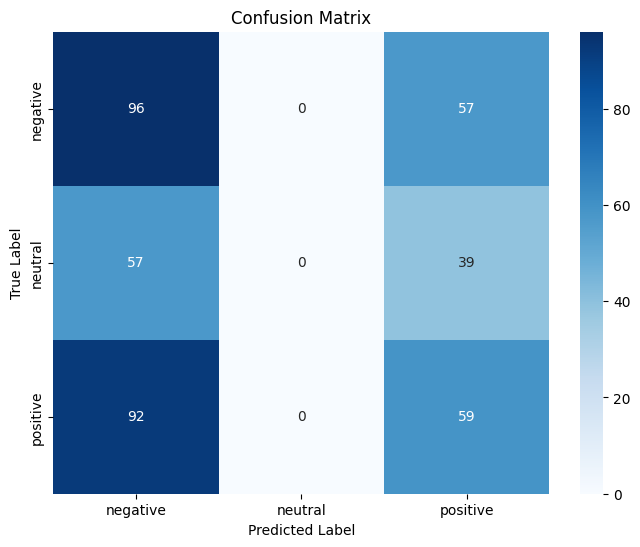

In [ ]:
vocab_size = 5000
embedding_output_dim = 128 # Dimensi output EmbeddingLayer
rnn_units_uni = 64
num_classes_uni = 3 # Untuk klasifikasi 3 kelas
h5_file_uni_keraslike = '../data/unidirectional.weights.h5'

# Definisikan model dengan arsitektur yang sesuai
my_model_uni = Model()
my_model_uni.add(EmbeddingLayer(vocab_size=vocab_size, embedding_dim=embedding_output_dim))
my_model_uni.add(SimpleRNNLayer(units=rnn_units_uni, activation='tanh', return_sequences=False))
my_model_uni.add(DropoutLayer(rate=0.2))
my_model_uni.add(DenseLayer(units=128, activation='relu'))
my_model_uni.add(DropoutLayer(rate=0.2))
my_model_uni.add(DenseLayer(units=num_classes_uni, activation='softmax'))

try:
    my_model_uni.load_weights(h5_file_uni_keraslike)

except Exception as e:
    print(f"ERROR dalam contoh Unidirectional: {e}")
    import traceback
    traceback.print_exc()

y_pred = my_model_uni.forward(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Uji Model Bidirectional

Processing Layers: |████████████████████████████████████████| 100.00%
              precision    recall  f1-score   support

    negative       0.59      0.52      0.56       153
     neutral       0.56      0.60      0.58        96
    positive       0.74      0.79      0.77       151

    accuracy                           0.65       400
   macro avg       0.63      0.64      0.64       400
weighted avg       0.64      0.65      0.64       400



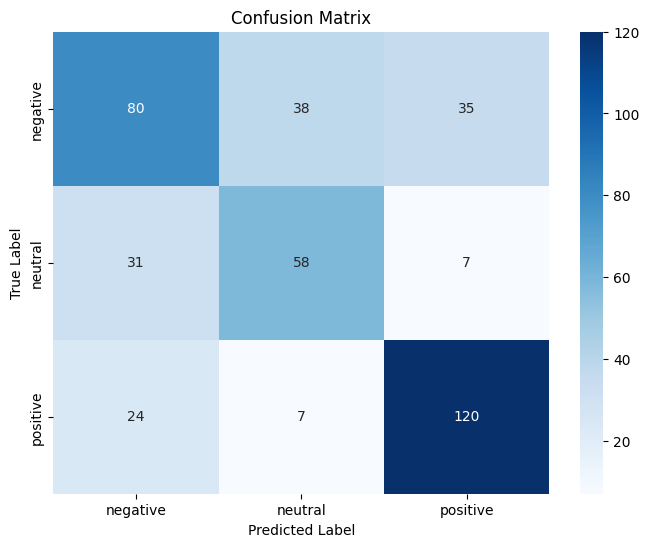

In [ ]:
vocab_size = 5000
embedding_output_dim = 128 # Dimensi output EmbeddingLayer
rnn_units_uni = 64
num_classes_uni = 3 # Untuk klasifikasi 3 kelas
h5_file_uni_keraslike = '../data/bidirectional.weights.h5'

# Definisikan model dengan arsitektur yang sesuai
my_model_uni = Model()
my_model_uni.add(EmbeddingLayer(vocab_size=vocab_size, embedding_dim=embedding_output_dim))
my_model_uni.add(BidirectionalSimpleRNNLayer(units=rnn_units_uni, activation='tanh', return_sequences=False))
my_model_uni.add(DropoutLayer(rate=0.2))
my_model_uni.add(DenseLayer(units=128, activation='relu'))
my_model_uni.add(DropoutLayer(rate=0.2))
my_model_uni.add(DenseLayer(units=num_classes_uni, activation='softmax'))

try:
    my_model_uni.load_weights(h5_file_uni_keraslike)

except Exception as e:
    print(f"ERROR dalam contoh Unidirectional: {e}")
    import traceback
    traceback.print_exc()

y_pred = my_model_uni.forward(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, labels=[0, 1, 2], target_names=label_encoder.classes_ ))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()